In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Read csv files into dataframes
patient_baseline = pd.read_csv("patient_baseline.csv", sep="\t")
patient_longitudinal = pd.read_csv("patient_longitudinal.csv", sep="\t")
patient_treatment = pd.read_csv("patient_treatment.csv", sep="\t")

In [ ]:
# Time Series Tasks
# Drop Dublicate rows
patient_longitudinal = patient_longitudinal.drop_duplicates()
# Change the time column into datetime format
patient_longitudinal["visit_date"] = pd.to_datetime(patient_longitudinal["visit_date"], format='%Y-%m-%d')
# Add time zone to all timepoints and Localize all of them to UTC zone
patient_longitudinal["visit_date"] = patient_longitudinal["visit_date"].dt.tz_localize('America/New_York').dt.tz_convert('UTC')


In [ ]:
# Create a pandas Series with DatetimeIndex using visit_date (values are from blood pressure column)
ts = pd.Series(data = patient_longitudinal["bp_systolic"].values, index = patient_longitudinal["visit_date"])
# Resample time series into months (calculate average value for each month)
# Interpolate timepoints without values
ts_monthly = ts.resample('ME').mean().interpolate()
# Calculate 3-month moving averages to smooth out fluctuations
ts_three_months = ts_monthly.rolling(window = 3, min_periods = 1).mean()

: 

In [ ]:
# Plot the timeseries, monthly means and 3-month moving average of blood pressure values
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
ts.plot(ax = ax1, title='Original')
ts_monthly.plot(ax = ax2, title='Monthly')
ts_three_months.plot(ax = ax3, title='Three months')

: 

***Blood Pressure Trends From 2023 to 2027***

The original plot shows high variability and noise obscure the trend, making it difficult to discern any clear pattern.

The monthly resampled plot reveals a general decrease in blood pressure with periodic bumps (in 2025 and 2026), though some short-term sharp fluctuations remain.

The 3-Month moving average smooths out the monthly fluctuations further, clearly showing the downward trend and bumps without sharpness. This approach best highlights the overall trend without excessive detail from month-to-month changes.

In [ ]:
# Statistical Modeling Tasks
# Predictors
X = patient_longitudinal[["age", "bmi", "smoking", "diabetes"]]
# Outcome
Y = patient_longitudinal['bp_systolic']
# Add constant to the X
X = sm.add_constant(X)  
# Linear regression model
model = sm.OLS(Y, X)
# Fit the model
results = model.fit()
# Model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2720.
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:40:39   Log-Likelihood:            -2.6000e+05
No. Observations:               61000   AIC:                         5.200e+05
Df Residuals:                   60995   BIC:                         5.201e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.3741      0.448    246.434      0.0

***Linear Regression Model for Blood Pressure Prediction***

The coefficients and P-values show that all age, bmi, smoking and diabetes are significantly associated with blood presuure. Diabetes with highest coefficient (9.7) has the strongest association and smoking (coef = 5.5) has the second strongest association with blood pressure.

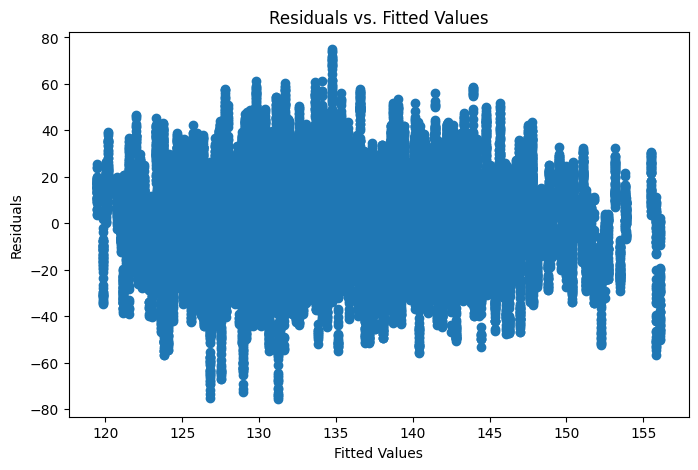

In [65]:
# Plot residuals vs fitted values 
plt.figure(figsize=(8, 5))
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

***Residuals Plot***

Since the residuals appear as a random cloud of points scattered around zero, the model is likely capturing the relationship between the predictors and the outcome well.

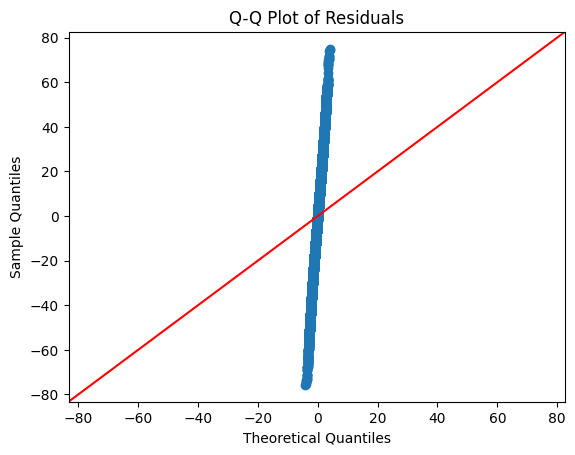

In [66]:
# Q-Q plot
sm.qqplot(results.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

***Q-Q Plot***

A vertical line in the Q-Q plot indicates unusually low variability in residuals, which often happens due to overfitting or low variability in the outcome variable. 

In [ ]:
# GLM
# Predictors
X = patient_treatment[["age", "bmi", "sex", "smoking", "diabetes", "adherence"]]
# Add constant
X = sm.add_constant(X)
# Outcome
Y = patient_treatment['treatment']
# GLM model
model = sm.GLM(Y, X, family=sm.families.Binomial())
# Fit the model
results = model.fit()
# Model summary
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              treatment   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      993
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -632.42
Date:                Tue, 05 Nov 2024   Deviance:                       1264.8
Time:                        23:04:44   Pearson chi2:                     993.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08890
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2578      0.720     -3.135      0.0

***GLM Model for Treatment Success Prediction***

This GLM suggests that age, BMI, smoking, and diabetes are associated with the likelihood of treatment success, with age and diabetes showing the strongest associations. However, sex and adherence do not show statistically significant effects. The modest pseudo R-squared suggests that while the model provides some insight, other unobserved factors may also influence treatment success.

In [85]:
# Odds ratios and their confidence intervals
odds_ratios = np.exp(results.params)
conf = results.conf_int()
conf_odds_ratios = np.exp(conf)
conf_odds_ratios.columns = ['Lower limit 95% CI', 'Upper limit 95% CI']
# Display odds ratios with confidence intervals
odds_ratios_with_ci = pd.DataFrame({'OR': odds_ratios, 'Lower limit 95% CI': conf_odds_ratios['Lower limit 95% CI'], 'Upper limit 95% CI': conf_odds_ratios['Upper limit 95% CI']})
print(odds_ratios_with_ci)

                 OR  Lower limit 95% CI  Upper limit 95% CI
const      0.104585            0.025495            0.429024
age        1.028131            1.018031            1.038331
bmi        1.030880            1.001984            1.060611
sex        1.166469            0.895218            1.519909
smoking    1.581735            1.055148            2.371123
diabetes   2.040594            1.438984            2.893726
adherence  1.017119            0.265101            3.902402


***Odds Ratios and Confidence Intervals***

In this model, smoking, and diabetes are statistically significant powerful predictors of treatment success. Age and bmi are also slightly associated to treatment success with statistical significance. However, the effect of sex and adherence is not statistically significant, suggesting that these factors may not be meaningful predictors in this dataset.

In [ ]:
# Assess model fit using deviance
print("Null Deviance:", results.null_deviance)
print("Residual Deviance:", results.deviance)
print("Deviance Reduction:", results.null_deviance - results.deviance)


Null Deviance: 1357.9360734835336
Residual Deviance: 1264.836965483575
Deviance Reduction: 93.0991079999585


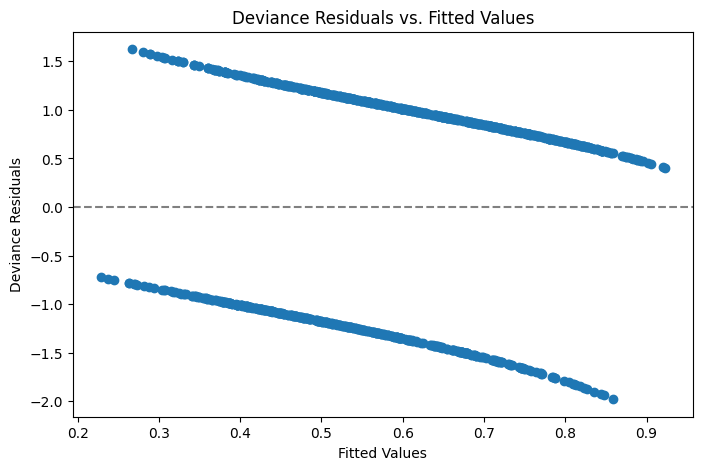

In [ ]:
# Deviance residuals vs. fitted values
plt.figure(figsize=(8, 5))
plt.scatter(results.fittedvalues, results.resid_deviance)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals vs. Fitted Values')
plt.show()


***Residual Deviance and Fitted Values plot***

The two parallel lines in the residuals vs. fitted values plot likely stem from the binary nature of the outcome, with the residuals clustering around two levels based on the predicted probabilities. This pattern indicates that the model is generally differentiating between the classes but with a consistent pattern in residuals.
However, there may be some overfitting or a need to check for class imbalance.


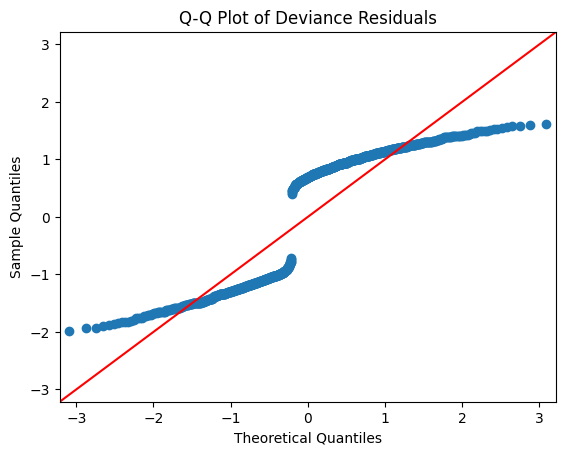

In [94]:
# Q-Q plot for deviance residuals
sm.qqplot(results.resid_deviance, line='45')
plt.title('Q-Q Plot of Deviance Residuals')
plt.show()

***Q-Q plot of Devians Residuals***

The two lines in the Q-Q plot are typical for binomial models and represent the residual structure for binary outcomes, with each line reflecting the residuals for one outcome class. This is a common and expected result in logistic regression, indicating that the model is working appropriately for this type of data. However the slop of the lines created bt point may indicate that the variance of the residuals is lower than expected under a normal distribution.

In [96]:
# Calculate influence measures
influence = results.get_influence()
# Cook's Distance
cooks_d = influence.cooks_distance[0]

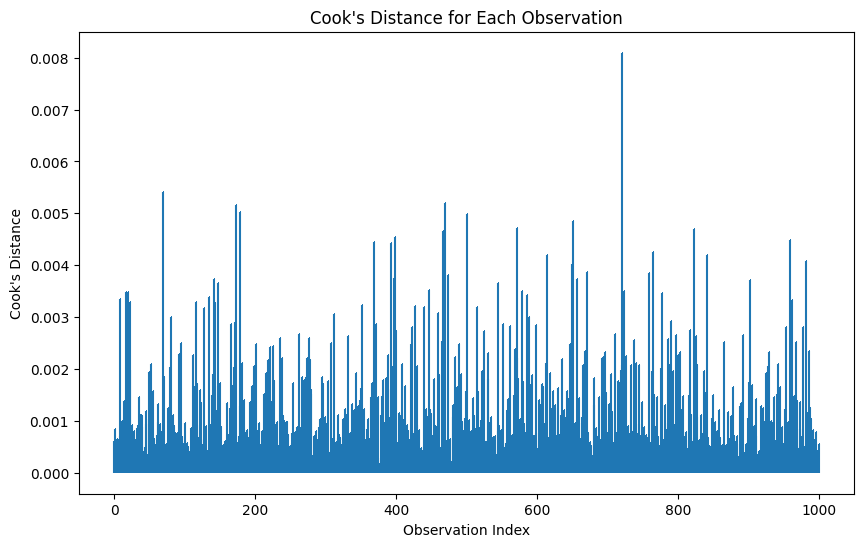

In [ ]:
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

***Cook’s Distance Plot***

The Cook's Distance values are all quite low, suggesting no extreme influential points in the data. The plot shows that no observation has a high Cook’s Distance, implying that the model's results are not heavily influenced by any single data point.